# Example: Using the PD Simulator for Mortgage Portfolio

This notebook demonstrates how to use the `pd_simulator.py` module from the `irbstudio.simulation` package to simulate Probability of Default (PD) for a mortgage portfolio.

We will:
1. Import required libraries
2. Import the `pd_simulator` module
3. Generate a realistic mortgage portfolio dataset (5000+ facilities with 36-month history)
4. Run the simulation using the `pd_simulator` module
5. Visualize the results

## 1. Import Required Libraries

We will use pandas for data manipulation and matplotlib for visualization. If you want interactive plots, you can also use plotly.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Optional: import plotly.express as px for interactive plots

# Set matplotlib to display plots inline
%matplotlib inline
import cProfile
import pstats

## 2. Import pd_simulator Module

We import the `pd_simulator` module from the `irbstudio.simulation` package. If running outside the package root, you may need to adjust the Python path.

In [2]:
from irbstudio.simulation.portfolio_simulator import PortfolioSimulator

## 4. Run PD Simulation

Now we'll configure the PD simulation and run it using the `pd_simulator` module. We'll set up the simulation parameters based on our mortgage portfolio characteristics.

In [3]:
sample_portfolio = 'freddie_mac'  # Options: 'artificial', 'freddie_mac'

# Define the score-to-rating boundaries based on the logic in sample_data.py
# These are used to map the output `simulated_pd` back to a `simulated_rating`.
# The keys are ratings, values are (lower_bound, upper_bound) of the PD.

if sample_portfolio == 'artificial':
    portfolio_df = pd.read_csv('../data/sample_portfolio_data.csv', parse_dates=['observation_date'])

    score_to_rating_bounds = {
        '1': (0.00, 0.001),
        '2': (0.001, 0.005),
        '3': (0.005, 0.01),
        '4': (0.01, 0.03),
        '5': (0.03, 0.10),
        '6': (0.10, 0.15),
        '7': (0.15, 0.25),
        '8': (0.25, 0.40),
        '9': (0.40, 1.60),
    }
    sorted_items = sorted(score_to_rating_bounds.items(), key=lambda x: x[1][0])
    labels = [item[0] for item in sorted_items]
    bounds = [item[1] for item in sorted_items]
    # Flatten bounds to get bin edges
    bin_edges = [bounds[0][0]] + [b[1] for b in bounds]
    # pd.cut is right-exclusive by default, so this matches min <= x < max
    ratings = pd.cut(portfolio_df['score'], bins=bin_edges, labels=labels, include_lowest=True, right=False)
    # Handle edge case: if score == max of last bin, assign last label
    last_max = bin_edges[-1]
    ratings = ratings.astype(object)
    ratings[portfolio_df['score'] == last_max] = labels[-1]
    portfolio_df['rating_new'] = ratings

    portfolio_df=portfolio_df
    score_to_rating_bounds=score_to_rating_bounds
    rating_col='rating_new'
    loan_id_col='facility_id'
    date_col='observation_date'
    default_col='default_flag'
    into_default_flag_col='into_default_flag'
    score_col='score'
    asset_correlation=0.15
    target_auc=0.90

elif sample_portfolio == 'freddie_mac':
    # Freddie Mac score to rating mapping

    rating_col='rating'
    loan_id_col='Loan_Sequence_Number'
    date_col='reporting_date'
    default_col='default_flag'
    into_default_flag_col='into_default_flag'
    score_col='score'
    

    cols = [rating_col, loan_id_col, date_col, default_col, into_default_flag_col, score_col]
    portfolio_df = pd.read_csv('../data/sample_portfolio_data_fm.csv', usecols=cols, parse_dates=[date_col])

    score_to_rating_bounds = {'1': (-1,0.003613294451497495),
        '2': (0.003613294451497495,0.005780360195785761),
        '3': (0.005780360195785761,0.03225071728229523),
        '4': (0.03225071728229523,0.039578670635819435),
        '5': (0.039578670635819435,0.256146103143692),
        '6': (0.256146103143692,0.7653337121009827),
        '7': (0.7653337121009827,50)}

    portfolio_df=portfolio_df
    score_to_rating_bounds=score_to_rating_bounds
    asset_correlation=0.15
    target_auc=0.90

In [4]:
# example usage of OOP portfolio simulator
from datetime import datetime
simulator = PortfolioSimulator(
    portfolio_df=portfolio_df,
    score_to_rating_bounds=score_to_rating_bounds,
    rating_col=rating_col,
    loan_id_col=loan_id_col,
    date_col=date_col,
    default_col=default_col,
    into_default_flag_col=into_default_flag_col,
    score_col=score_col,
    application_start_date=datetime(2024,4,1),
    asset_correlation=asset_correlation,
    exposure_col=None,
    target_auc=target_auc,
    random_seed=None
)

In [7]:
profiler = cProfile.Profile()
profiler.enable()
simulator.prepare_simulation()
results = simulator.run_monte_carlo(num_iterations=1)
profiler.disable()
stats = pstats.Stats(profiler).sort_stats('cumtime')
stats.print_stats(30)  # Print top 10 functions by cumulative time

2025-09-29 11:36:13 - irbstudio.simulation.portfolio_simulator - INFO - Starting portfolio simulation preparation.
2025-09-29 11:36:13 - irbstudio.simulation.portfolio_simulator - INFO - Segmenting portfolio into historical and application samples.
2025-09-29 11:36:14 - irbstudio.simulation.portfolio_simulator - INFO - Historical sample size: 6069488; Application sample size: 2593086
2025-09-29 11:36:14 - irbstudio.simulation.portfolio_simulator - INFO - Segmenting application sample into new and existing clients.
2025-09-29 11:36:16 - irbstudio.simulation.portfolio_simulator - INFO - Existing clients: 2266470, New clients: 326616
2025-09-29 11:36:17 - irbstudio.simulation.portfolio_simulator - INFO - Fitting Beta Mixture Model to historical scores.
2025-09-29 11:36:17 - irbstudio.simulation.distribution - INFO - Supervised fitting complete.
2025-09-29 11:36:17 - irbstudio.simulation.distribution - INFO - Non-Default (C0): alpha=2.36, beta=431.43, weight=0.99
2025-09-29 11:36:17 - irbs

In [6]:
stats.print_stats(30)

         3792670 function calls (3790650 primitive calls) in 18.444 seconds

   Ordered by: cumulative time
   List reduced from 1708 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      118    0.062    0.001   21.876    0.185 C:\Users\jacek\AppData\Local\Programs\Python\Python313\Lib\selectors.py:310(select)
      119    2.446    0.021   19.466    0.164 {built-in method select.select}
      118    0.110    0.001   18.672    0.158 C:\Users\jacek\AppData\Local\Programs\Python\Python313\Lib\selectors.py:304(_select)
      118    0.028    0.000   10.241    0.087 C:\Users\jacek\AppData\Local\Programs\Python\Python313\Lib\asyncio\base_events.py:1970(_run_once)
      4/3    0.011    0.003    6.699    2.233 {built-in method builtins.exec}
        3    0.000    0.000    6.345    2.115 c:\Users\jacek\Desktop\Projects\IRBStudio\.venv\Lib\site-packages\IPython\core\interactiveshell.py:3663(run_code)
        1    0.033    0.033    6.334    6.

In [12]:
result_df = results[0]

In [13]:
result_df.groupby('rating')['simulated_rating'].value_counts().unstack().fillna(0).round(2)

simulated_rating,20,1,2,3,4,5,6,7
rating,,,,,,,,
1,0.0,3485625.0,192742.0,48851.0,1010.0,5788.0,1011.0,0.0
2,0.0,2348616.0,140294.0,40588.0,390.0,3475.0,649.0,0.0
3,0.0,2090979.0,159168.0,55723.0,569.0,4488.0,457.0,32.0
4,0.0,22554.0,1740.0,907.0,0.0,41.0,15.0,0.0
5,0.0,36079.0,2669.0,1794.0,1.0,46.0,8.0,0.0
6,0.0,10707.0,2330.0,3108.0,4.0,37.0,1.0,0.0
7,0.0,72.0,5.0,1.0,0.0,0.0,0.0,0.0
20,49132.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
check_df = result_df[result_df['into_default_flag'].notna()]
check_df = check_df[check_df['default_flag'] == 0]
check_df = check_df.loc[check_df[date_col] < pd.to_datetime('2024-04-30')]

In [15]:
from sklearn.metrics import roc_auc_score
roc_auc_score(check_df['into_default_flag'], check_df['simulated_score'])

0.9059805126997351

<Axes: xlabel='simulated_rating', ylabel='Density'>

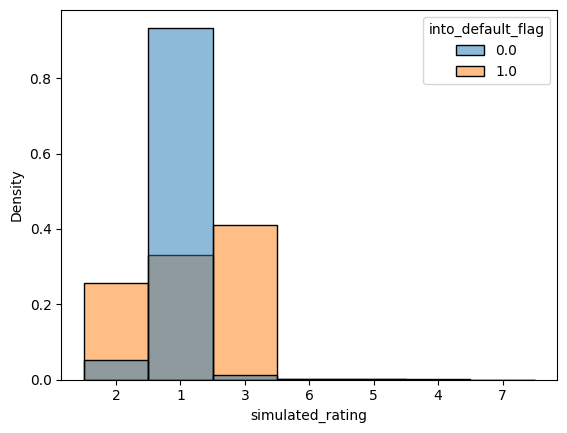

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(check_df, x = 'simulated_rating', hue='into_default_flag', stat='density', common_norm=False, bins=30)


## 5. Analyze and Visualize Simulation Results

Let's analyze the key results from our mortgage portfolio simulation and create some useful visualizations.

In [13]:
# Perform basic analysis of simulation results, if the simulation was successful
if not result_df.empty:
    # Use the most recent simulated data for analysis
    analysis_df = result_df.sort_values(date_col).groupby(loan_id_col).last().reset_index()

    # 1. Analyze rating migration from original to simulated
    migration_matrix = pd.crosstab(
        analysis_df['rating'], 
        analysis_df['simulated_rating'],
        normalize='index'
    )

    print("Rating migration matrix (Original vs. Simulated):")
    print(migration_matrix.round(3))



    # 3. Summarize simulated portfolio quality
    final_default_rate = (analysis_df['simulated_rating'] == 'D').mean()
    print(f"\nFinal simulated default rate: {final_default_rate:.4f} ({final_default_rate*100:.2f}%)")

    # Prepare data for visualization
    visualization_data = {
        'migration_matrix': migration_matrix,
        'rating_transitions': analysis_df[['rating', 'simulated_rating']],
    }
else:
    print("Simulation did not produce results. Skipping analysis.")
    visualization_data = {}

Rating migration matrix (Original vs. Simulated):
simulated_rating   20      1      2      3      4      5    6
rating                                                       
1                 0.0  0.931  0.052  0.015  0.000  0.001  0.0
2                 0.0  0.923  0.055  0.019  0.000  0.002  0.0
3                 0.0  0.877  0.086  0.035  0.000  0.002  0.0
4                 0.0  0.839  0.112  0.047  0.001  0.001  0.0
5                 0.0  0.873  0.080  0.044  0.000  0.003  0.0
6                 0.0  0.869  0.082  0.047  0.002  0.000  0.0
7                 0.0  1.000  0.000  0.000  0.000  0.000  0.0
20                1.0  0.000  0.000  0.000  0.000  0.000  0.0

Final simulated default rate: 0.0000 (0.00%)


UFuncTypeError: ufunc 'greater' did not contain a loop with signature matching types (<class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.StrDType'>) -> None

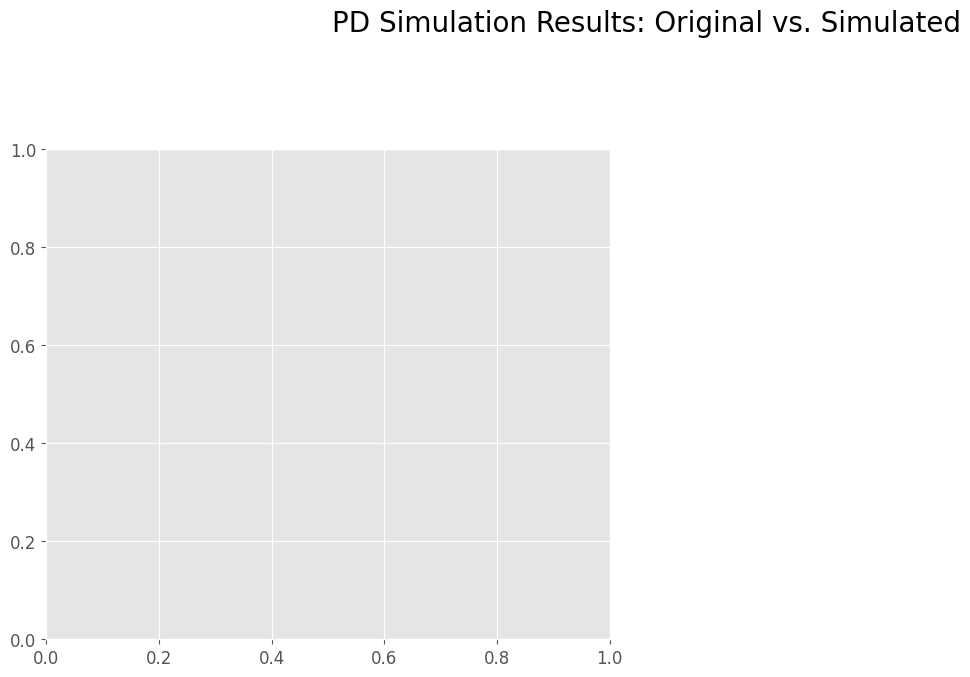

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Set up a more professional plot style
plt.style.use('ggplot')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

if visualization_data:
    # Create a figure with subplots for key visualizations
    fig = plt.figure(figsize=(16, 14))
    fig.suptitle('PD Simulation Results: Original vs. Simulated', fontsize=20)

    # 1. Heatmap of migration matrix
    ax1 = plt.subplot(2, 2, 1)
    colors = ["green", "white", "red"]
    cm = LinearSegmentedColormap.from_list("custom", colors, N=100)

    def sort_ratings(ratings):
        numeric_ratings = sorted([r for r in ratings if r != 'D'])
        return numeric_ratings + ['D'] if 'D' in ratings else numeric_ratings

    migration_matrix = visualization_data['migration_matrix']
    row_ratings = sort_ratings(migration_matrix.index)
    col_ratings = sort_ratings(migration_matrix.columns)
    sorted_matrix = migration_matrix.reindex(index=row_ratings, columns=col_ratings).fillna(0)

    sns.heatmap(sorted_matrix, cmap=cm, annot=True, fmt='.3f', 
                linewidths=0.5, ax=ax1, vmin=0, vmax=1, cbar_kws={'label': 'Transition Probability'})
    ax1.set_title('Rating Migration Matrix (Original to Simulated)')
    ax1.set_xlabel('Simulated Rating')
    ax1.set_ylabel('Original Rating')

    # 2. Rating distribution before and after simulation
    ax2 = plt.subplot(2, 2, 2)
    rating_transitions = visualization_data['rating_transitions']
    start_counts = rating_transitions['rating'].value_counts().sort_index()
    end_counts = rating_transitions['simulated_rating'].value_counts().sort_index()
    
    rating_counts = pd.DataFrame({'Original': start_counts, 'Simulated': end_counts}).fillna(0)
    sorted_ratings = sort_ratings(rating_counts.index)
    rating_counts = rating_counts.reindex(sorted_ratings)

    rating_counts.plot(kind='bar', ax=ax2)
    ax2.set_title('Rating Distribution: Original vs. Simulated')
    ax2.set_xlabel('Rating')
    ax2.set_ylabel('Number of Facilities')
    ax2.grid(True, alpha=0.3)

    # 3. PD distribution comparison (violin plot)
    ax3 = plt.subplot(2, 2, 3)

    ax3.set_title('PD Distribution: Original vs. Simulated')
    ax3.set_ylabel('Probability of Default (PD)')

    # 4. PD comparison by original rating
    ax4 = plt.subplot(2, 2, 4)
    pd_full_comparison = analysis_df[['rating', 'simulated_pd']].copy()
    
    
    ax4.set_title('PD by Original Rating')
    ax4.set_xlabel('Original Rating')
    ax4.set_ylabel('Probability of Default (PD)')
    ax4.legend(title='PD Type')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

else:
    print("No data to visualize.")

## Conclusion

This example demonstrates how to use the PD simulator module to model default risk in a mortgage portfolio. The simulation provides valuable insights into:

1. **Default Rates**: The monthly and cumulative default rates across different scenarios.

2. **Rating Migration**: How mortgages transition between rating categories over time.

3. **Risk Factors**: The relationship between LTV ratios and default probability.

4. **Portfolio Quality**: Changes in the overall distribution of ratings from start to end.

These insights can be used for:
- Regulatory capital calculations
- IFRS 9/CECL expected credit loss estimation
- Stress testing
- Mortgage portfolio risk management
- Pricing and underwriting strategy

By using the `pd_simulator` module, financial institutions can efficiently model credit risk in their mortgage portfolios without implementing complex simulation logic from scratch.

In [50]:
result_df.shape

(8711706, 11)

In [51]:
result_df.loc[result_df['score'] <= 0.01].shape

(8015944, 11)